SVM — алгоритм обучения с учителем. Наглядно многие алгоритмы машинного обучения можно посмотреть в этой топовой статье (см. раздел «Карта мира машинного обучения»). Нужно добавить, что SVM может применяться и для задач регрессии, но в данной статье будет разобран SVM-классификатор.


Главная цель SVM как классификатора — найти уравнение разделяющей гиперплоскости вида w1x1 + w2x2 + ... + wnxn = 0 в пространстве , которая бы разделила два класса неким оптимальным образом. Общий вид преобразования F объекта x  в метку класса Y: F(x) = sign(x*w^t -  b) . Будем помнить, что мы обозначили . После настройки весов алгоритма  и  (обучения), все объекты, попадающие по одну сторону от построенной гиперплоскости, будут предсказываться как первый класс, а объекты, попадающие по другую сторону — второй класс.

Внутри функции  стоит линейная комбинация признаков объекта с весами алгоритма, именно поэтому SVM относится к линейным алгоритмам. Разделяющую гиперплоскость можно построить разными способами, но в SVM веса  и  настраиваются таким образом, чтобы объекты классов лежали как можно дальше от разделяющей гиперплоскости. Другими словами, алгоритм максимизирует зазор (англ. margin) между гиперплоскостью и объектами классов, которые расположены ближе всего к ней. Такие объекты и называют опорными векторами. Отсюда и название алгоритма.



Чтобы разделяющая гиперплоскость как можно дальше отстояла от точек выборки, ширина полосы должна быть максимальной. Вектор w — вектор нормали к разделяющей гиперплоскости. Здесь и далее будем обозначать скалярное произведение двух векторов как (a, b)  или (b*a^T) .Давайте найдем проекцию вектора, концами которого будут являться опорные вектора разных классов на вектор w. Эта проекция и будет показывать ширину разделяющий полосы.


In [1]:
# Подключим библиотеки
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


In [2]:
# функция отрисовки линии
def newline(p1, p2, color=None): 
    
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l

In [3]:
# функциякоторая автоматически расширяет вектор объектов,
# добавляя в конец каждого вектора число 1.
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended

# Описываем класс
class CustomSVM(object):
    
    __class__ = "CustomSVM"

    # Функция инициализации:    
    def __init__(self, etha=0.01, alpha=0.1, epochs=200):
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        self._w = None
        self.history_w = []
        self.train_errors = None
        self.val_errors = None
        self.train_loss = None
        self.val_loss = None
    
    # Функция обучения:  
    def fit(self, X_train, Y_train, X_val, Y_val, verbose=False): #arrays: X; Y =-1,1
        
        if len(set(Y_train)) != 2 or len(set(Y_val)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")
        
        X_train = add_bias_feature(X_train)
        X_val = add_bias_feature(X_val)
        self._w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        self.history_w.append(self._w)
        train_errors = []
        val_errors = []
        train_loss_epoch = []
        val_loss_epoch = []
        
        for epoch in range(self._epochs): 
            tr_err = 0
            val_err = 0
            tr_loss = 0
            val_loss = 0
            for i,x in enumerate(X_train):
                margin = Y_train[i]*np.dot(self._w,X_train[i])
                # классифицируем верно
                if margin >= 1: 
                    
                    self._w = self._w - self._etha*self._alpha*self._w/self._epochs
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                    
                else: # классифицируем неверно или попадаем на полосу разделения при 0<m<1
                    
                    self._w = self._w +\
                    self._etha*(Y_train[i]*X_train[i] - self._alpha*self._w/self._epochs)
                    tr_err += 1
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                    
                self.history_w.append(self._w)
                
            for i,x in enumerate(X_val):
                
                val_loss += self.soft_margin_loss(X_val[i], Y_val[i])
                val_err += (Y_val[i]*np.dot(self._w,X_val[i])<1).astype(int)
                
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'\
                      .format(epoch,err,loss))
                
            train_errors.append(tr_err)
            val_errors.append(val_err)
            train_loss_epoch.append(tr_loss)
            val_loss_epoch.append(val_loss)
            
        self.history_w = np.array(self.history_w)    
        self.train_errors = np.array(train_errors)
        self.val_errors = np.array(val_errors)
        self.train_loss = np.array(train_loss_epoch)
        self.val_loss = np.array(val_loss_epoch)                    
            
    # Функция вычисления прогноза
    def predict(self, X:np.array) -> np.array:
        y_pred = []
        X_extended = add_bias_feature(X)
        
        for i in range(len(X_extended)):
            
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
            
        return np.array(y_pred)         
    
    
    def hinge_loss(self, x, y):
        return max(0,1 - y*np.dot(x, self._w))
    
    
    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x,y)+self._alpha*np.dot(self._w, self._w)

In [4]:
# блок подготовки данных
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)*2-1 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

[69 34 25 19 14 14 13 11  7  7  5  6  5  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  3  3  3  3  1  2  1  2  1  2  1  2  1  2
  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  1  2  1  2  1  2  1  2  1
  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  1  2
  1  2  1  2  1  2  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[ 0.94694069 -0.89055016  1.19197883]


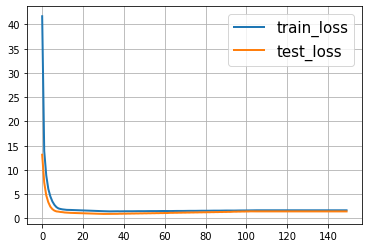

In [5]:
# блок инициализиции и обучения
svm = CustomSVM(etha=0.005, alpha=0.006, epochs=150)
svm.fit(X_train, Y_train, X_test, Y_test)


print(svm.train_errors) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

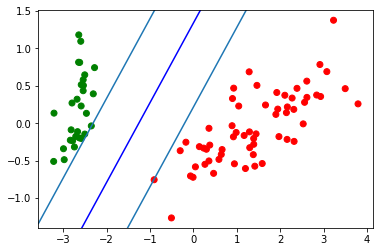

In [6]:
# Блок визуализации получившейся разделяющей полосы:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

Количество ошибок для отложенной выборки:  0


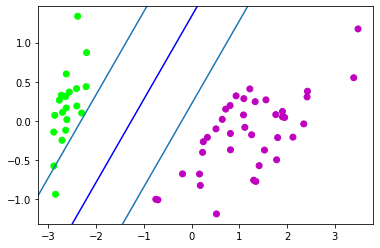

In [7]:
# Убеждаемся, что все объекты из отложенной выборки классифицируются правильно
# предсказываем после обучения

y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error

print('Количество ошибок для отложенной выборки: ', (y_pred == -100).astype(int).sum())

d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error

plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

In [8]:
# блок подготовки данных
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y == 2).astype(int)*2-1 # [0,1,2] --> [False,False,True] --> [0,1,1] --> [0,0,2] --> [-1,1,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

[49 40 35 31 29 26 24 25 25 25 24 24 23 23 24 22 22 20 22 22 19 18 17 17
 17 17 17 20 17 17 17 17 17 17 15 17 15 15 15 14 15 15 15 14 15 15 15 14
 15 15 15 15 14 15 15 15 14 15 15 15 12 13 12 13 12 13 12 13 12 13 12 13
 12 13 12 13 12 13 12 13 12 13 11 12 11 12 13 11 12 11 12 11 12 11 12 11
 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11 12 11
 12 11 12 11 12 11 12 11 12 11 12 11 10 11 12 10 11 12 10 11 10 10 10 11
 10 10 10 10 11 10]
[ 4.36265594 -2.2510587  -5.6228221 ]


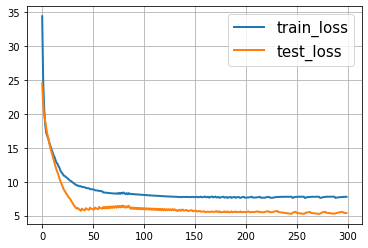

In [9]:
# блок инициализиции и обучения
svm = CustomSVM(etha=0.03, alpha=0.0001, epochs=300)
svm.fit(X_train, Y_train, X_test, Y_test)


print(svm.train_errors[:150]) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

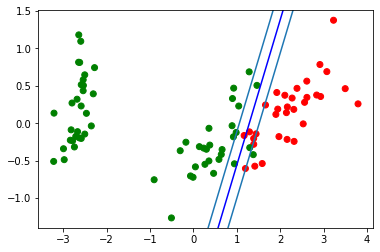

In [10]:
# Блок визуализации получившейся разделяющей полосы после обработок:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

Количество ошибок для отложенной выборки:  2


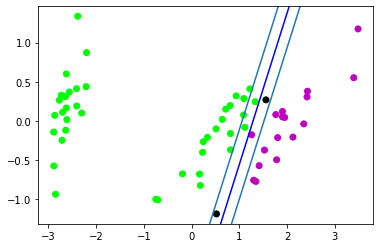

In [11]:
# Блок визуализации прогноза:
# предсказываем после обучения
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error
print('Количество ошибок для отложенной выборки: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error
plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

In [12]:
from sklearn import svm
from sklearn.metrics import recall_score

C = 1.0  # = self._alpha in our algorithm
model1 = svm.SVC(kernel='linear', C=C)
#model1 = svm.LinearSVC(C=C, max_iter=10000)
#model1 = svm.SVC(kernel='rbf', gamma=0.7, C=C)
#model1 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)

model1.fit(X_train, Y_train)
y_predict = model1.predict(X_test)
print(recall_score(Y_test, y_predict, average=None))

[0.97619048 0.94444444]


In [13]:
# Функция потерь
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter


def one_image(w, X, Y):
    axes = plt.gca()
    axes.set_xlim([-4,4])
    axes.set_ylim([-1.5,1.5])
    d1 = {-1:'green', 1:'red'}
    im = plt.scatter(X[:,0], X[:,1], c=[d1[y] for y in Y])
    im = newline([0,-w[2]/w[1]],[-w[2]/w[0],0], 'blue')
#    im = newline([0,1/w[1]-w[2]/w[1]],[1/w[0]-w[2]/w[0],0], 'lime') #w0*x_i[0]+w1*x_i[1]+w2*1=1
#    im = newline([0,-1/w[1]-w[2]/w[1]],[-1/w[0]-w[2]/w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
    return im

In [14]:
# Или просто базовые возможности библиотеки Sklearn
from sklearn import svm
from sklearn.metrics import recall_score

C = 1.0  # = self._alpha in our algorithm
model1 = svm.SVC(kernel='linear', C=C)
#model1 = svm.LinearSVC(C=C, max_iter=10000)
#model1 = svm.SVC(kernel='rbf', gamma=0.7, C=C)
#model1 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)

model1.fit(X_train, Y_train)
y_predict = model1.predict(X_test)
print(recall_score(Y_test, y_predict, average=None))

[0.97619048 0.94444444]
